## Basline machine Learning for Emotion Detection

In [4]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [5]:
# data
#df = pd.read_csv(r'..\Data\German\features_german.csv')
#df = pd.read_csv(r'..\Data\Urdu\features_urdu.csv')
df = pd.read_csv(r'..\Data\English\features_english.csv')
df

,filename,emotion,speaker_id,valence,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,..\Data\English\DC\a01.wav,anger,1,0,32.288380,0.253543,28.019905,31.009491,34.035744,6.015839,...,-0.130033,-0.008058,0.175102,3.581267,2.234637,0.296250,0.255389,0.247500,0.217529,-15.691360
1,..\Data\English\DC\a02.wav,anger,1,0,28.624495,0.083322,27.068924,28.368698,29.564380,2.495457,...,-0.127977,-0.008800,0.123429,3.508772,0.890208,0.666667,0.507631,0.325000,0.268375,-15.941064
2,..\Data\English\DC\a03.wav,anger,1,0,32.756123,0.073900,30.584631,33.153530,34.469784,3.885153,...,-0.128269,-0.007824,0.087312,2.427185,0.995025,0.495000,0.265000,0.323333,0.197540,-13.958084
3,..\Data\English\DC\a04.wav,anger,1,0,30.764030,0.126925,28.082650,31.094275,33.430504,5.347855,...,-0.113702,-0.010014,0.088040,3.690037,1.127820,0.553333,0.402851,0.232500,0.181435,-13.020000
4,..\Data\English\DC\a05.wav,anger,1,0,32.762295,0.264996,28.170233,30.551094,34.771942,6.601709,...,-0.104462,-0.010390,0.082960,3.691275,1.706485,0.374000,0.653226,0.188000,0.185515,-13.182361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,..\Data\English\KL\su11.wav,surprise,4,1,27.108358,0.206385,20.513933,27.355312,32.252160,11.738226,...,-0.103756,-0.006573,0.020492,3.500000,2.051282,0.255000,0.085000,0.168000,0.148513,-38.530186
476,..\Data\English\KL\su12.wav,surprise,4,1,29.356766,0.251457,24.306232,27.609499,33.923824,9.617592,...,-0.091886,-0.008118,0.022205,4.370180,2.088773,0.361250,0.288593,0.123333,0.129957,-38.795590
477,..\Data\English\KL\su13.wav,surprise,4,1,29.011467,0.158787,25.771938,29.877594,32.168110,6.396172,...,-0.079930,-0.007662,0.010094,2.840909,1.734104,0.366667,0.174992,0.161429,0.146719,-37.637800
478,..\Data\English\KL\su14.wav,surprise,4,1,28.444344,0.174112,24.197416,28.833923,32.693607,8.496191,...,-0.077113,-0.007587,0.016008,3.238095,2.115385,0.270909,0.163120,0.165833,0.160803,-37.570038


In [6]:
df["speaker_id"].unique()

array([1, 2, 3, 4])

### Data Preprocessing
* we have a small dataset with unbalanced data. we need to be careful about overfitting. We want to have balanced data, so we use SMOTE to oversample the minority class (this usually works well for smaller datasets) 
* we need GroupKfold crossvalidation, as we do not want to have speakers from the training in the test dataset 

=> we do this all together in the pipepline

In [7]:
# check classes
df['valence'].value_counts()


valence
0    240
1    240
Name: count, dtype: int64

### Model Training

In [8]:
X = df.drop(["emotion", "speaker_id", "filename", "valence"], axis=1)  # Features
y = df["valence"]  # Labels
groups = df["speaker_id"]  

# Initialize GroupKFold with 5 folds 
#gkf = GroupKFold(n_splits=5)

# For the English dataset we initialize with 4 folds (since n = 4 < 5)
gkf = GroupKFold(n_splits=4)

# Initialize models
svm_model = SVC(probability=True, random_state=42)
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
xgb_model = XGBClassifier(random_state=42)
randomForest_model = RandomForestClassifier(random_state=42)

# Create pipelines
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", svm_model)
])

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", logreg_model)
])

xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", xgb_model)
])

randomForest_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", randomForest_model)
])

### Evaluation
in the paper they used unweighted average recall rate (UAR) which gives equal weight to each class, making it good for imbalanced datasets. UAR is the same as balanced accuracy.
we choose to check also other metrics, which are good for imbalanced date, like f1 score.

In [9]:
scoring_metrics = ["accuracy", "balanced_accuracy", "f1_weighted", "roc_auc_ovr", "precision_weighted", "recall_weighted"]
results = []

# Evaluate pipelines using different metrics
for metric in scoring_metrics:
    svm_scores = cross_val_score(svm_pipeline, X, y, groups=groups, cv=gkf, scoring=metric)
    logreg_scores = cross_val_score(logreg_pipeline, X, y, groups=groups, cv=gkf, scoring=metric)
    xgb_scores = cross_val_score(xgb_pipeline, X, y, groups=groups, cv=gkf, scoring=metric)
    randomForest_scores = cross_val_score(randomForest_pipeline, X, y, groups=groups, cv=gkf, scoring=metric)
    
    # Store results
    results.append(["SVM", metric, svm_scores.mean()])
    results.append(["Logistic Regression", metric, logreg_scores.mean()])
    results.append(["Random Forest", metric, randomForest_scores.mean()])
    results.append(["XGBoost", metric, xgb_scores.mean()])


results_df = pd.DataFrame(results, columns=["Model", "Metric", "Score"])
results_df

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Metric,Score
0,SVM,accuracy,0.589583
1,Logistic Regression,accuracy,0.597917
2,Random Forest,accuracy,0.570833
3,XGBoost,accuracy,0.550000
4,SVM,balanced_accuracy,0.589583
5,Logistic Regression,balanced_accuracy,0.597917
6,Random Forest,balanced_accuracy,0.570833
7,XGBoost,balanced_accuracy,0.550000
8,SVM,f1_weighted,0.548698
9,Logistic Regression,f1_weighted,0.553612


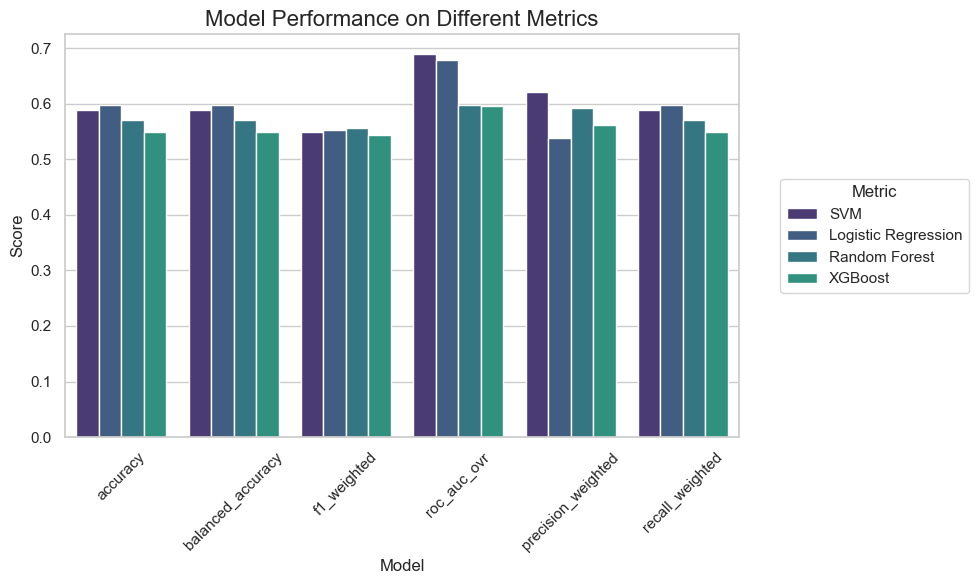

In [10]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
sns.barplot(data=results_df, x="Metric", y="Score", hue="Model")

# Add labels and title
plt.title('Model Performance on Different Metrics', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.legend(title="Metric", bbox_to_anchor=(1.05, 0.5), loc='center left')
# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
